# Image Inpainting with cVAE

In [1]:
import torch
import torchvision
from models.cvae import cVAE
from models.attentioncvae import Attention_cVAE
from datasets import celeba
from matplotlib import pyplot as plt
from datasets.inpainting import DeleteRandomRectangle, DeleteRectangle, DeleteSmilingRectangle, DeleteRandomBigRectangle
import numpy as np

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def crop(x, low, high):
    x[x <= low] = low
    x[x >= high] = high
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: crop(x, 0., 1.)),
    torchvision.transforms.Resize((109, 89), antialias=True),  # (3, 218, 178) -> (3, 109, 89)
    torchvision.transforms.CenterCrop((64, 64)),
])

train_data = celeba.CelebA(root='.', download=False, transform=transform, split="valid")


In [12]:
def display_reconstruction(generator, img_index, deletion, labels = [0,1]):
    img, _ = train_data[img_index]

    plt.figure(figsize=(15,15))

    num_pics = 2 + len(labels)*2

    plt.subplot(1, num_pics, 1)
    plt.imshow(img.squeeze().permute(1,2,0))

    cropped, mask = deletion(img.unsqueeze(0))
    plt.subplot(1, num_pics, 2)
    plt.imshow(cropped.squeeze().permute(1,2,0))
    
    for i, label in enumerate(labels):
        generated, _, _ = generator(cropped.to(device), torch.tensor([label], device=device))
        generated = generated.cpu().detach()
        plt.subplot(1, num_pics, 2 + 2*i + 1)
        plt.imshow(generated.squeeze().permute(1,2,0))
        
        result = img * (1 - mask) + generated * mask
        plt.subplot(1, num_pics, 2 + 2*i + 2)
        plt.imshow(result.cpu().detach().squeeze().permute(1,2,0))
    
    plt.show()

def display_reconstruction_no_deletion(generator, img_index, labels = [0,1]):
    img, _ = train_data[img_index]
    img = img.unsqueeze(0)

    plt.figure(figsize=(15,15))

    num_pics = 1 + len(labels)*2

    plt.subplot(1, num_pics, 1)
    plt.imshow(img.squeeze().permute(1,2,0))

    for i, label in enumerate(labels):
        generated, _, _ = generator(img.to(device), torch.tensor([label], device=device))
        generated = generated.cpu().detach()
        plt.subplot(1, num_pics, 1 + i + 1)
        plt.imshow(generated.squeeze().permute(1,2,0))
    
    plt.show()

## Inpainting smiles

13914723


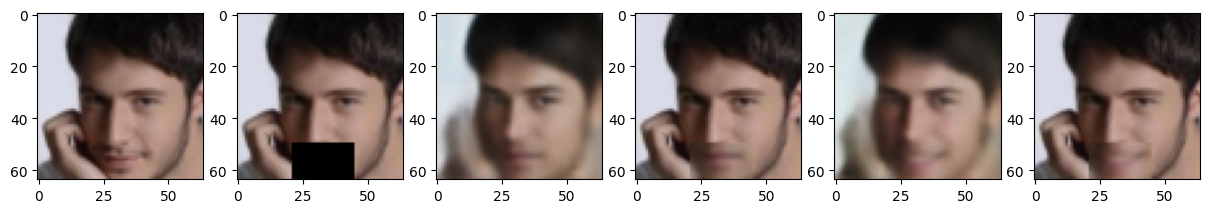

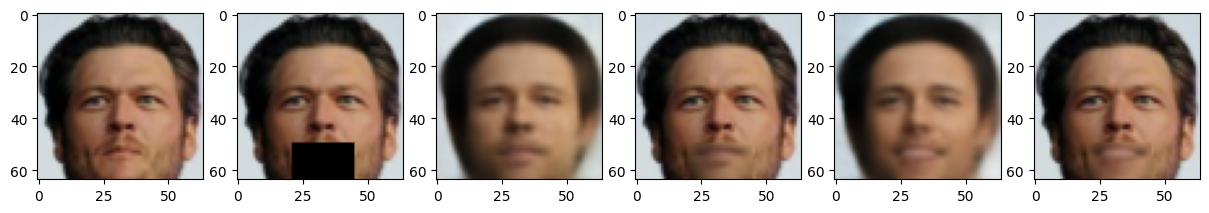

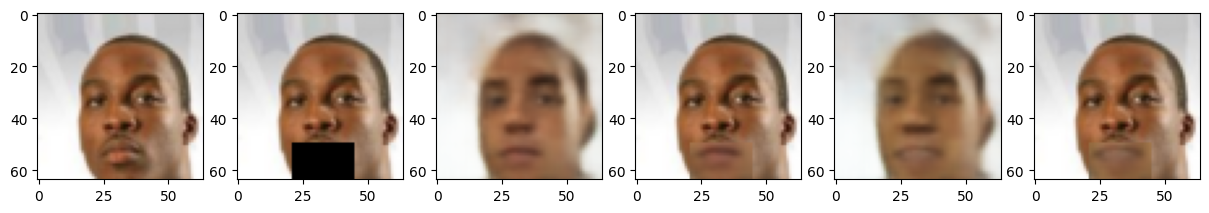

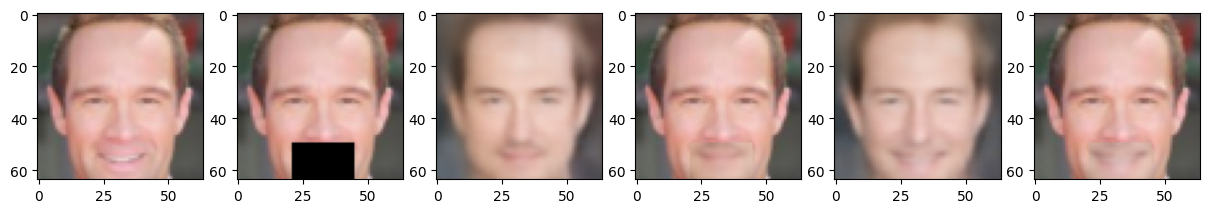

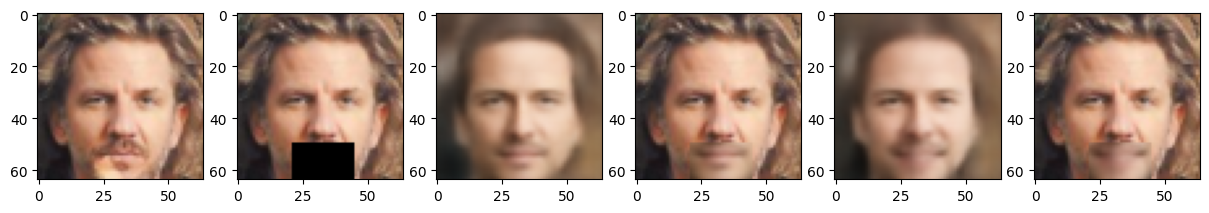

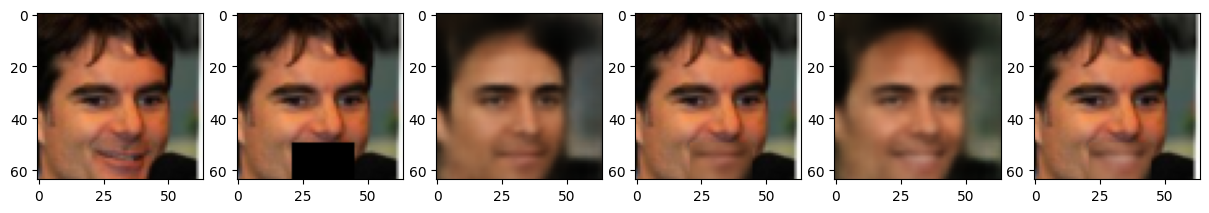

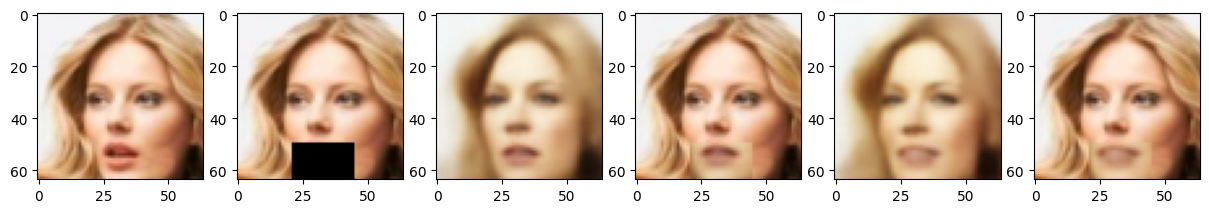

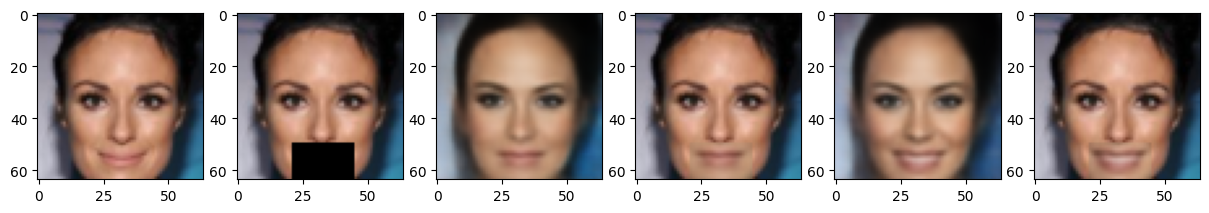

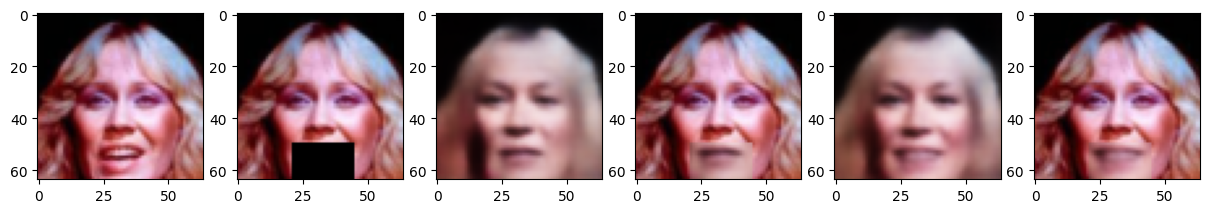

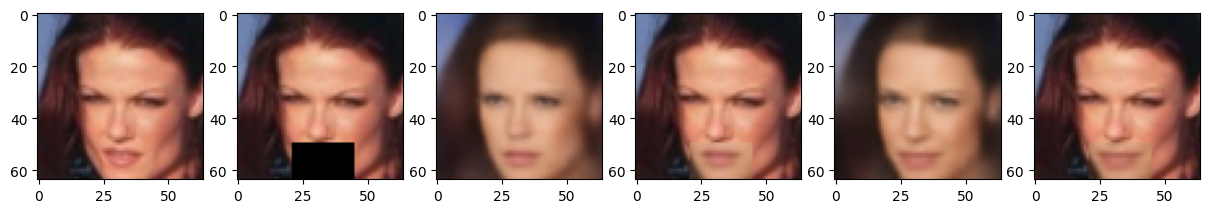

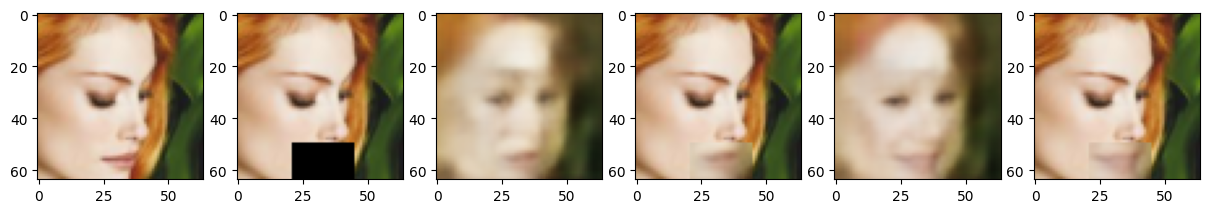

In [13]:
# Baseline cVAE

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/smiling-inpainter-baseline.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

deletion = DeleteSmilingRectangle()

for img_index in [8,12,53,1256,1212,99,231,144,11,1214,514]:
    display_reconstruction(model, img_index, deletion)

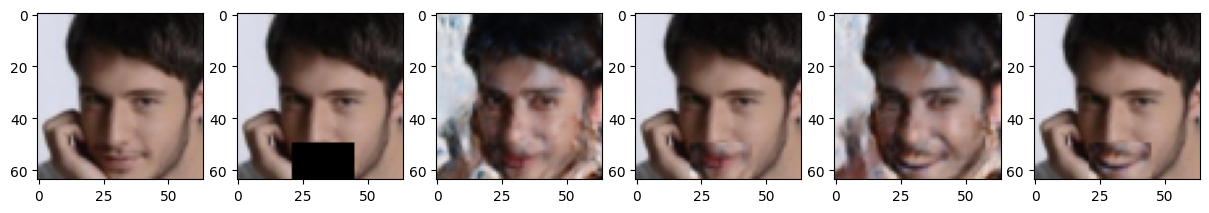

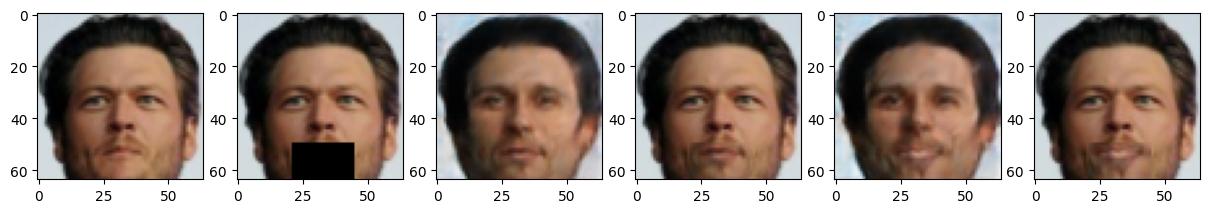

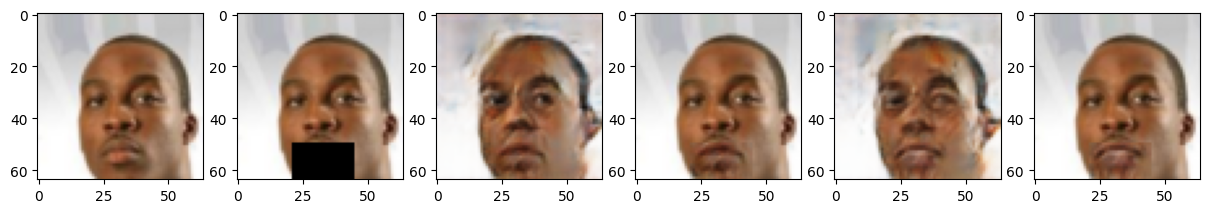

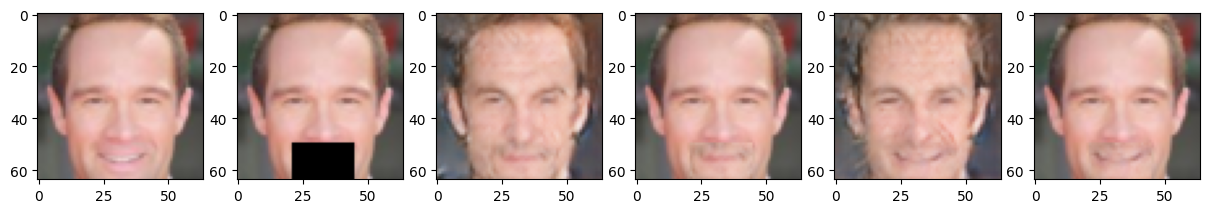

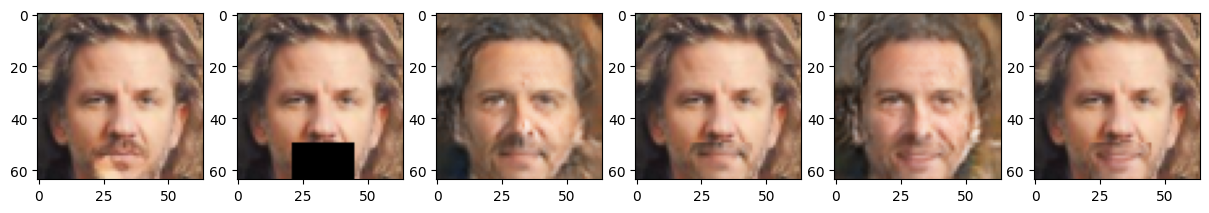

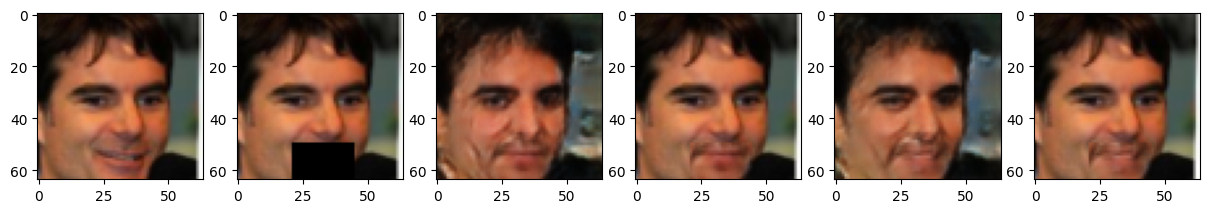

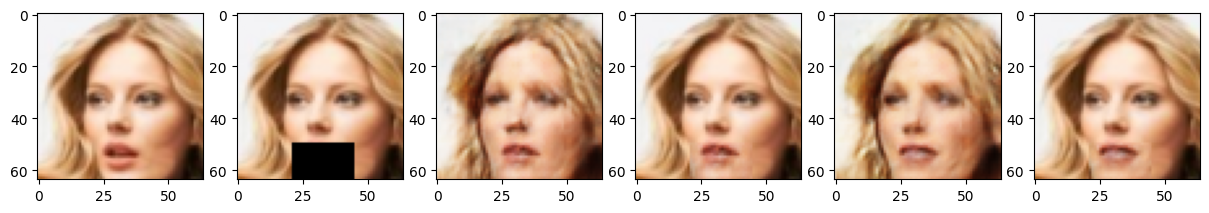

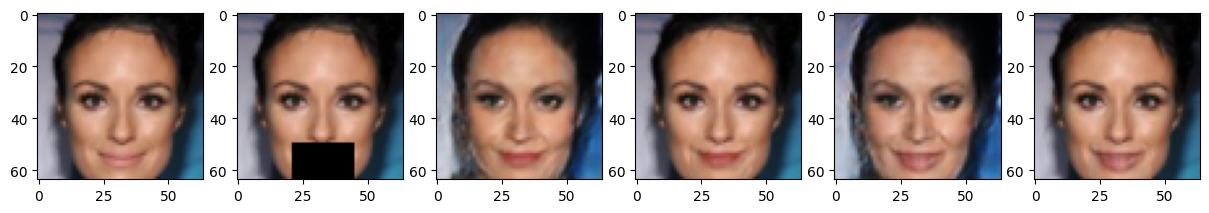

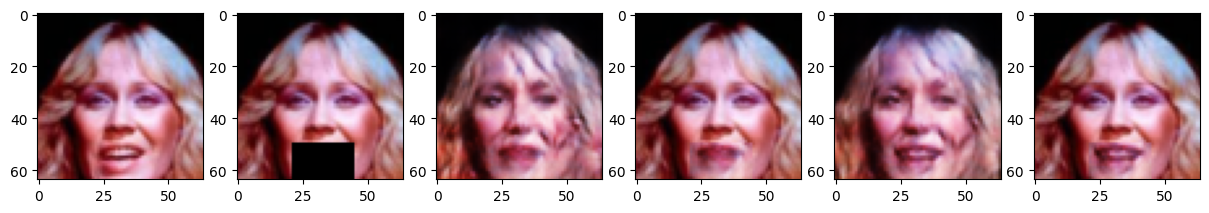

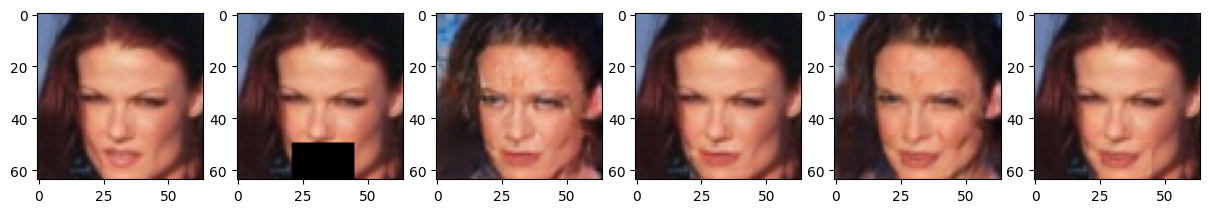

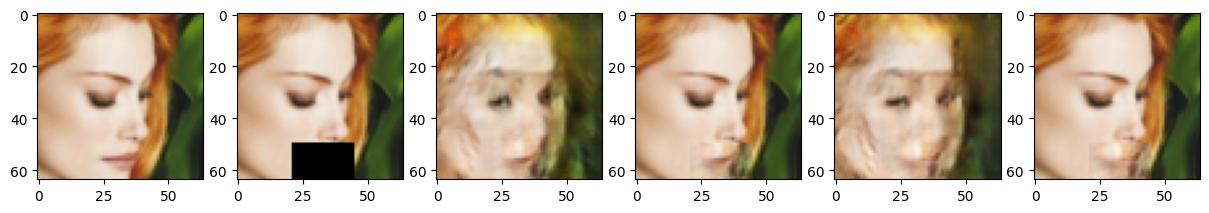

In [14]:
# cVAE finetuned with adversarial loss

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/smiling-inpainter.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteSmilingRectangle()

for img_index in [8,12,53,1256,1212,99,231,144,11,1214,514]:
    display_reconstruction(model, img_index, deletion)

# General inpainting

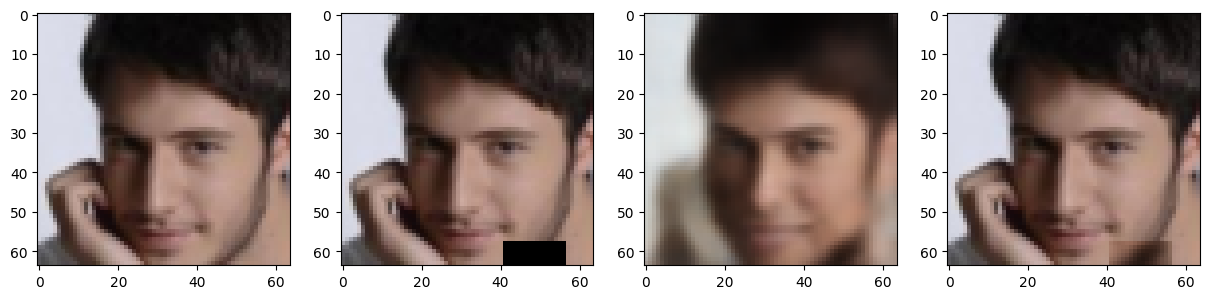

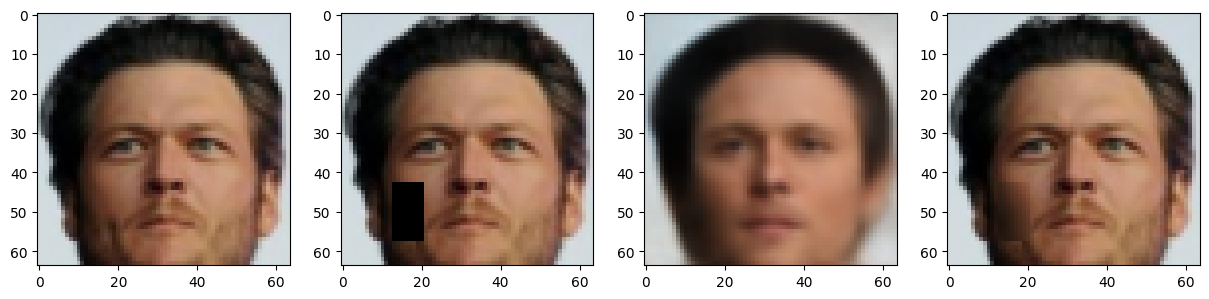

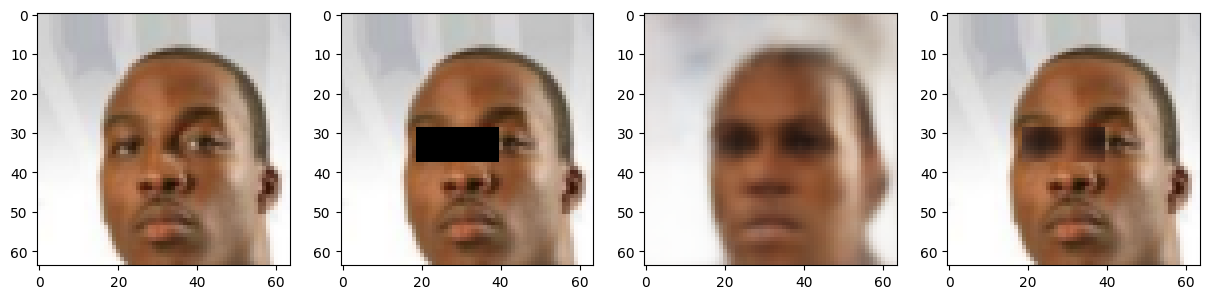

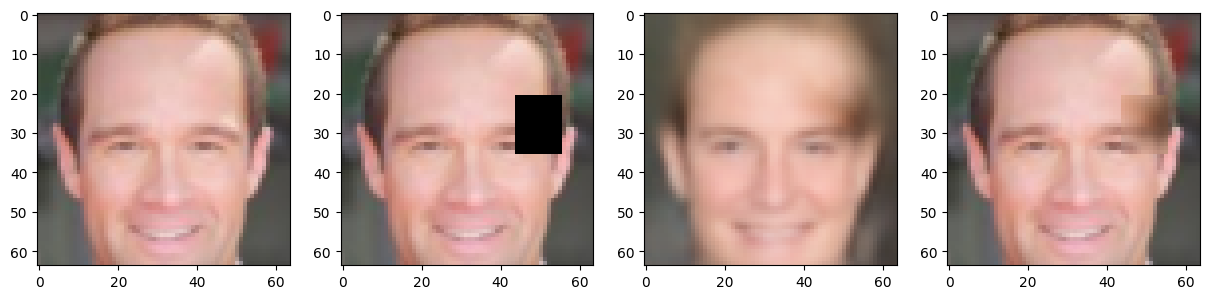

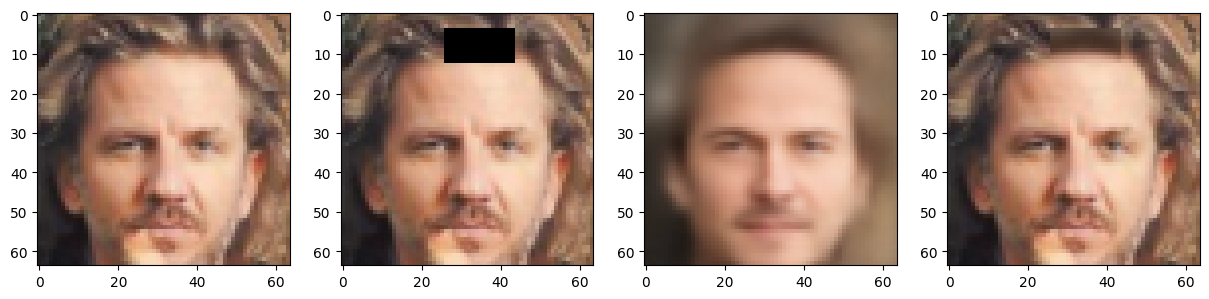

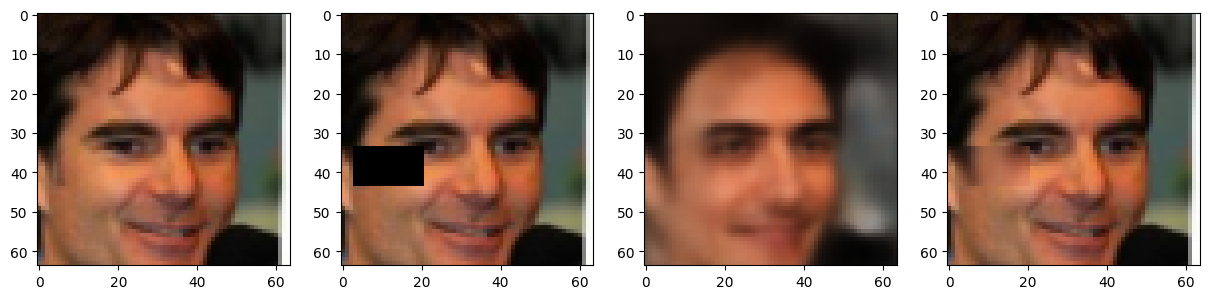

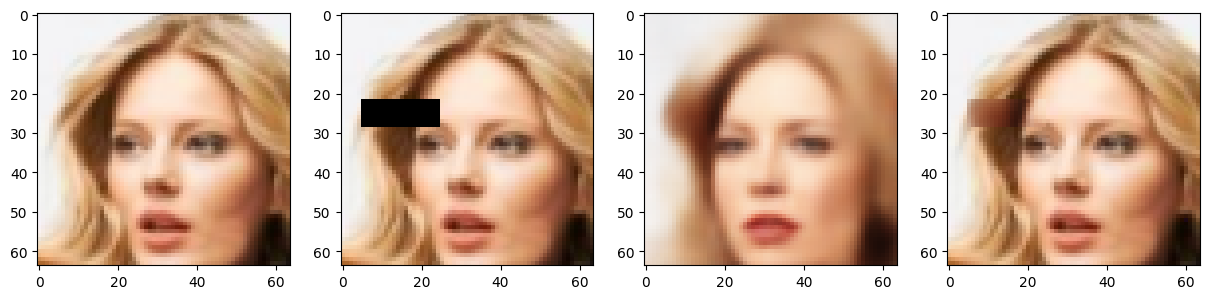

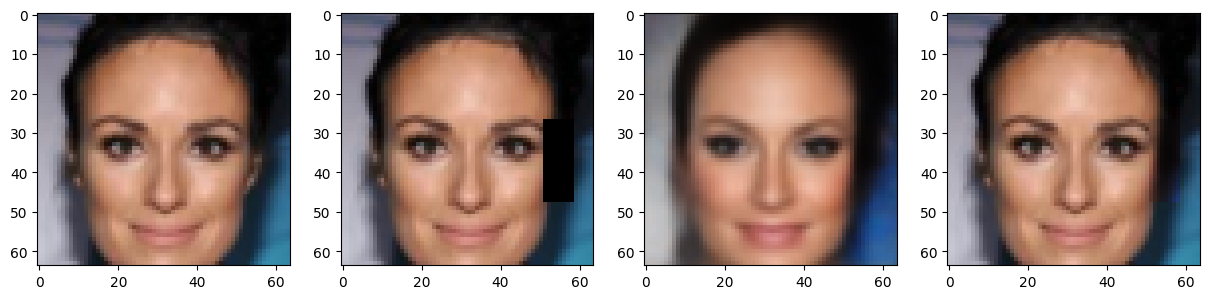

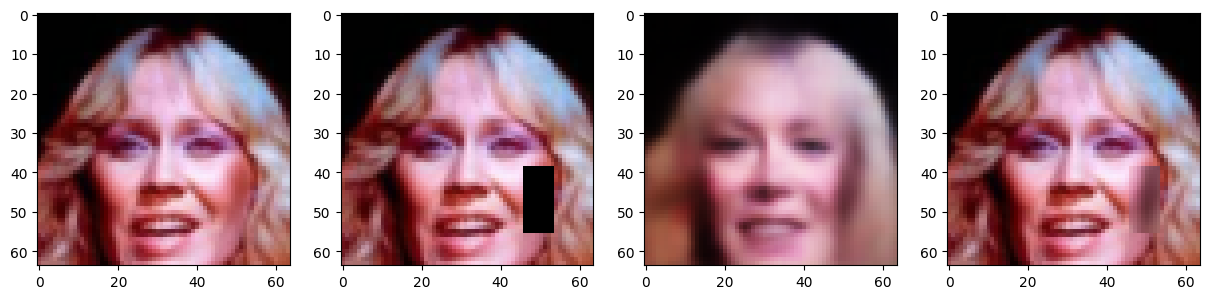

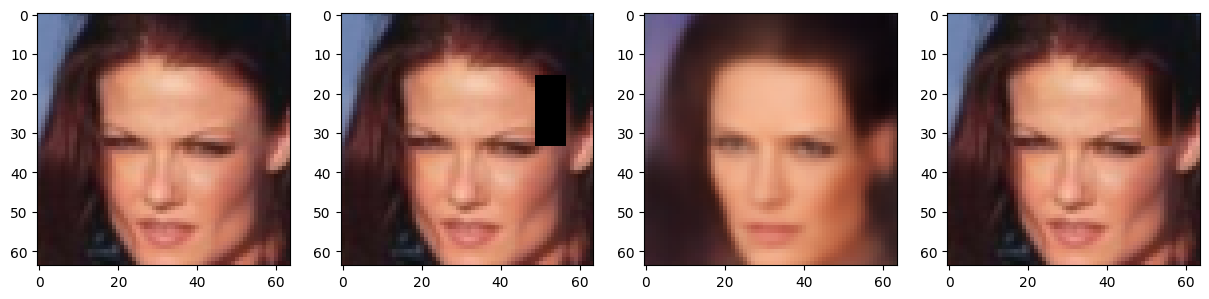

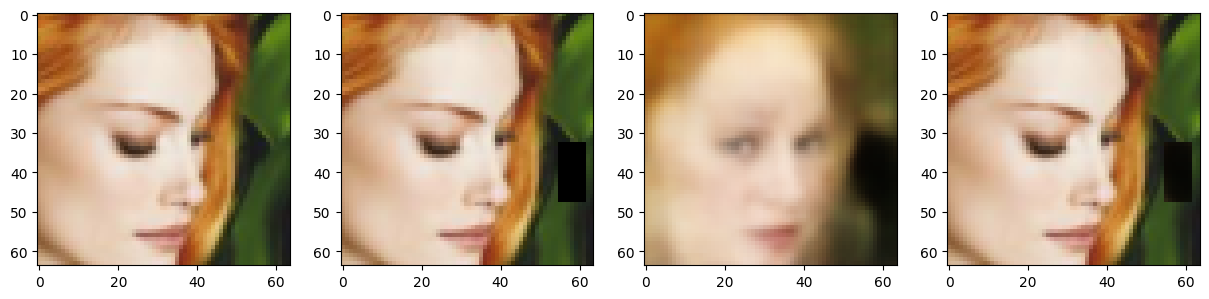

In [15]:
# Baseline cVAE

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/general-inpainter-baseline.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteRandomRectangle()

for img_index in [8,12,53,1256,1212,99,231,144,11,1214,514]:
    display_reconstruction(model, img_index, deletion, labels=[0])

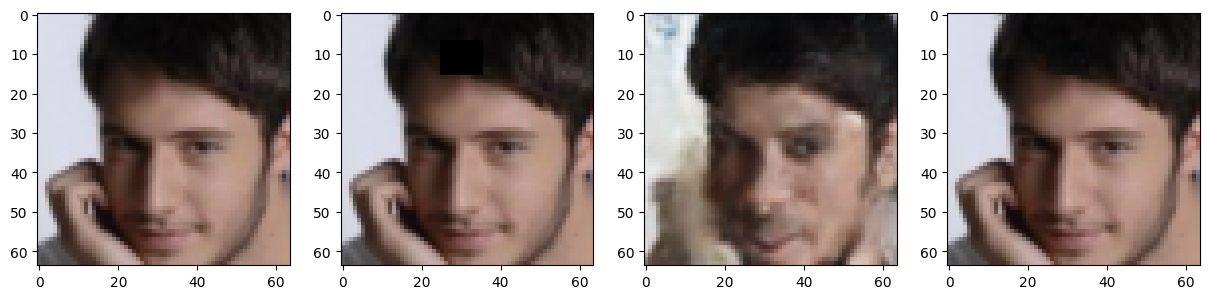

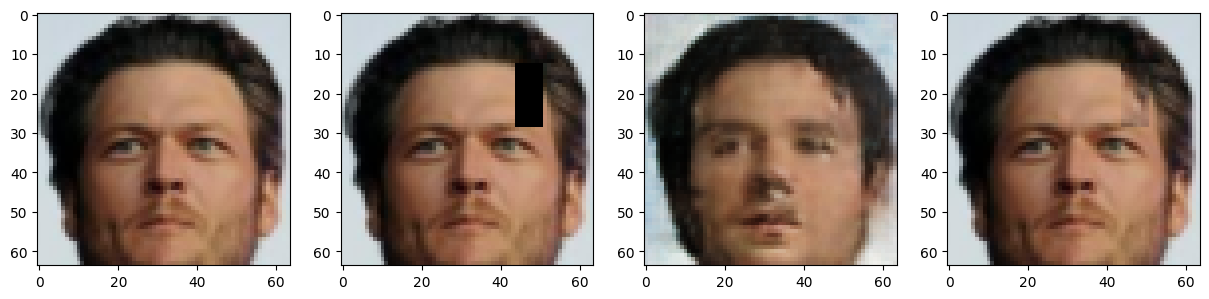

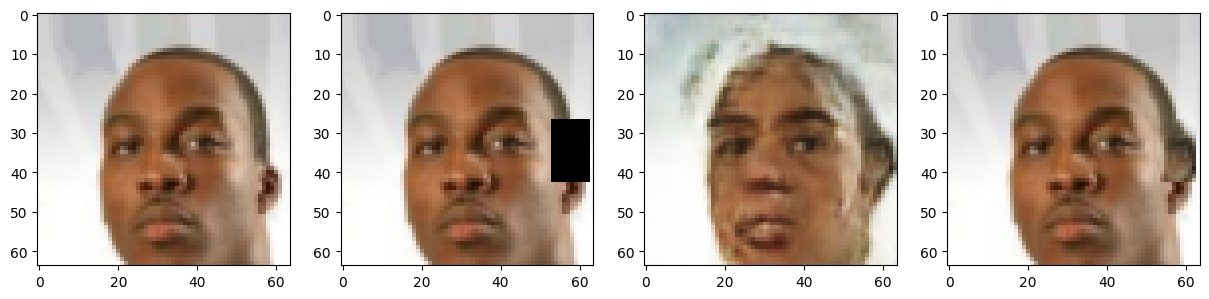

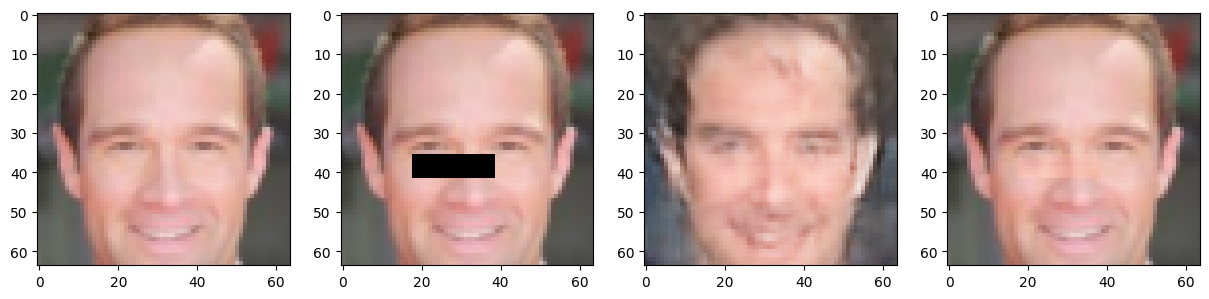

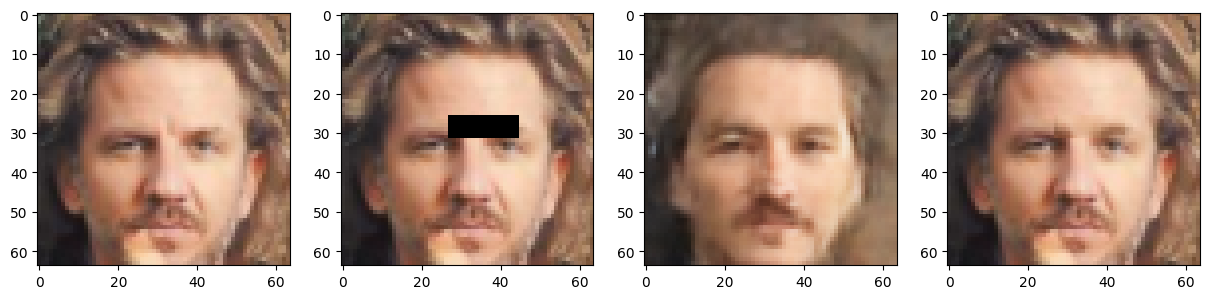

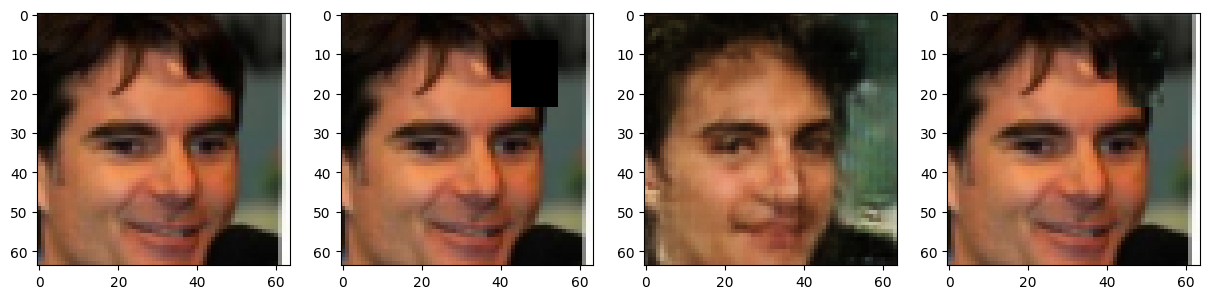

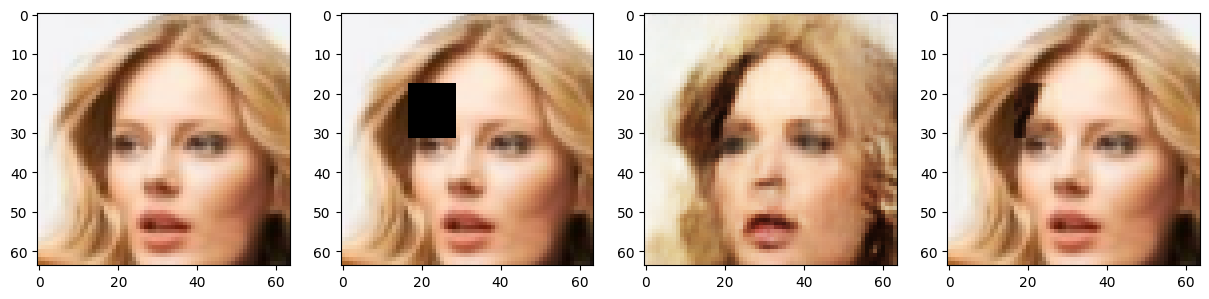

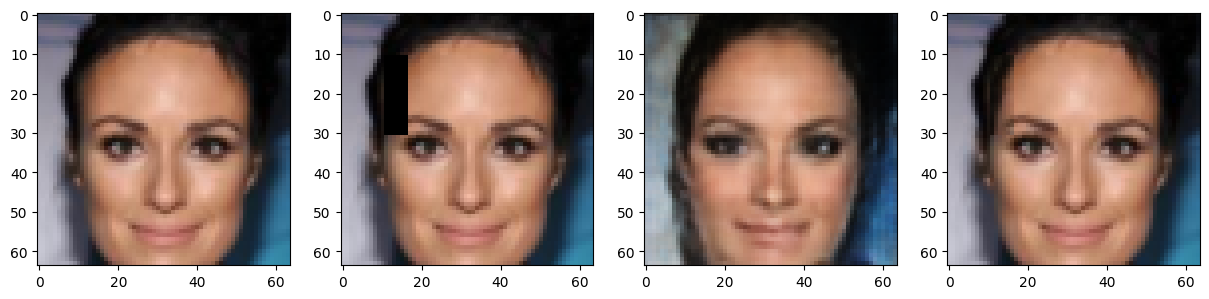

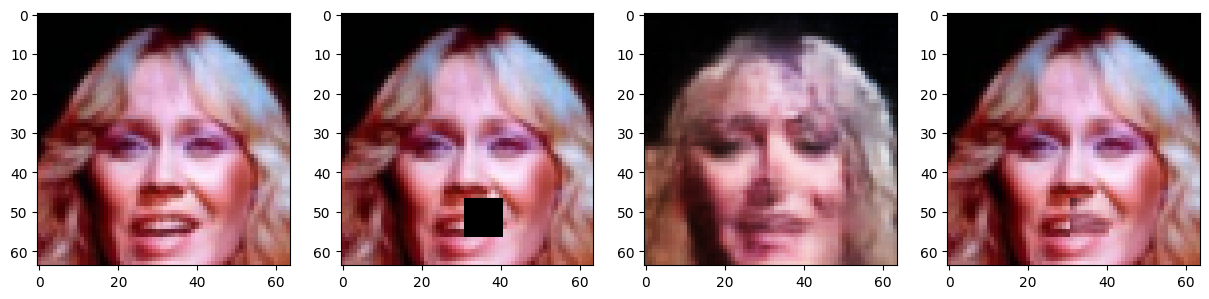

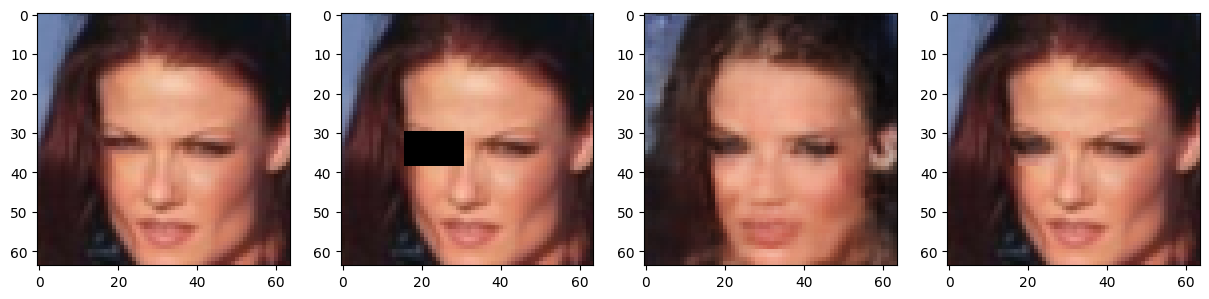

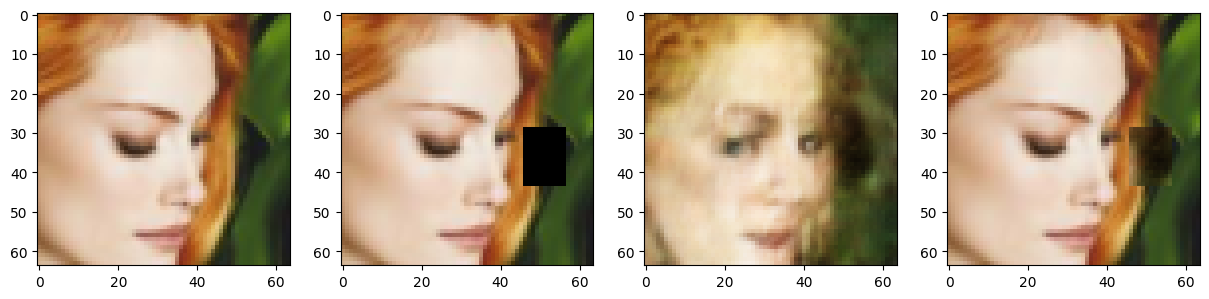

In [51]:
# cVAE finetuned with adversarial loss

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/general-inpainter.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteRandomRectangle()

for img_index in [8,12,53,1256,1212,99,231,144,11,1214,514]:
    display_reconstruction(model, img_index, deletion, labels=[0])

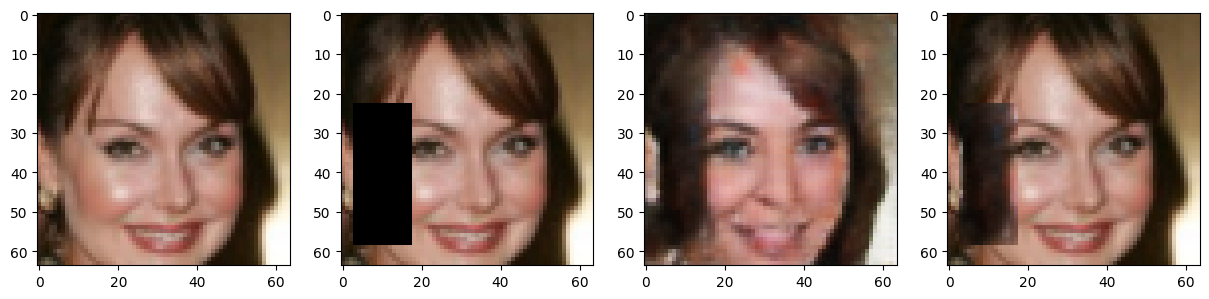

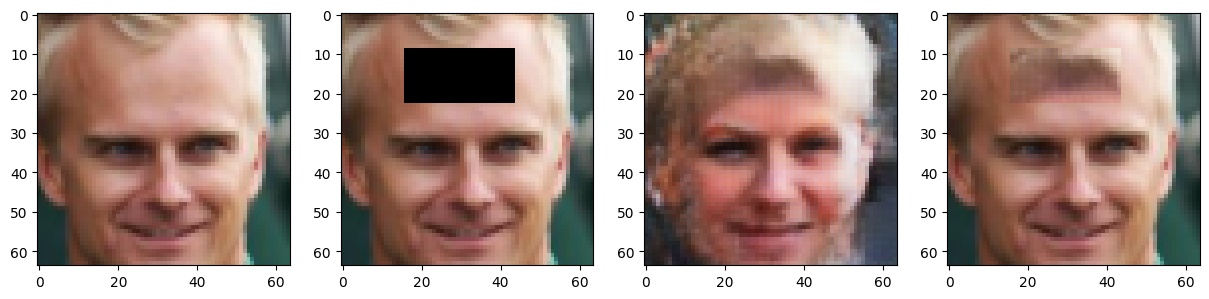

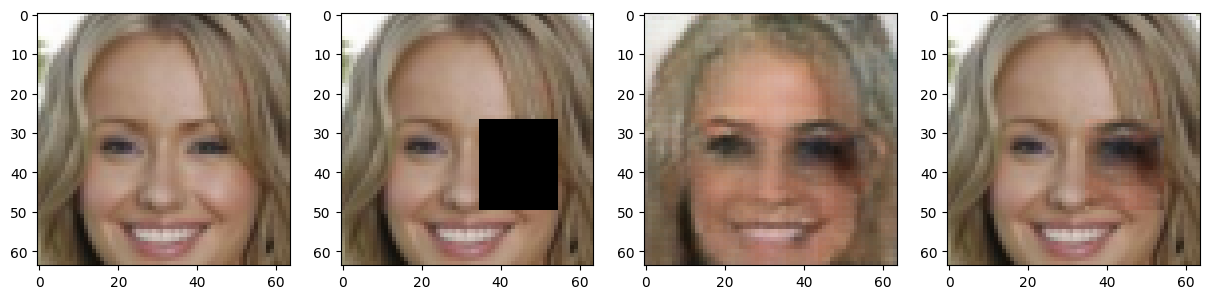

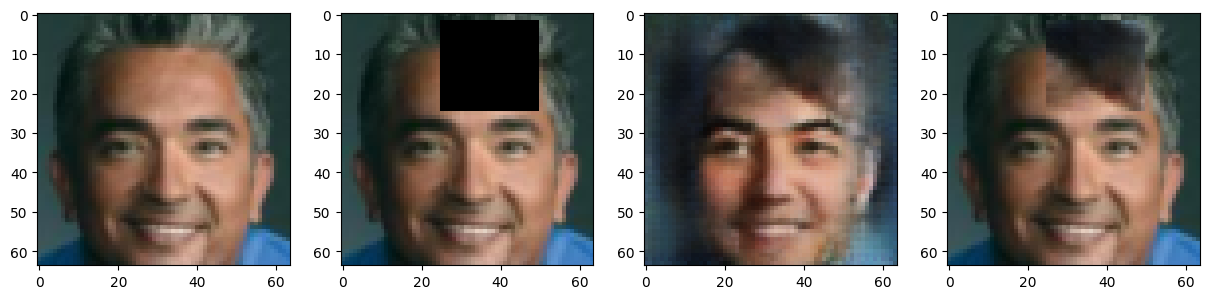

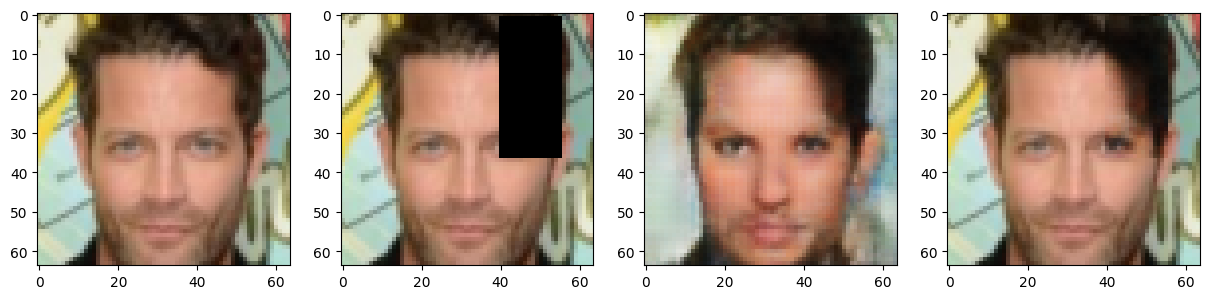

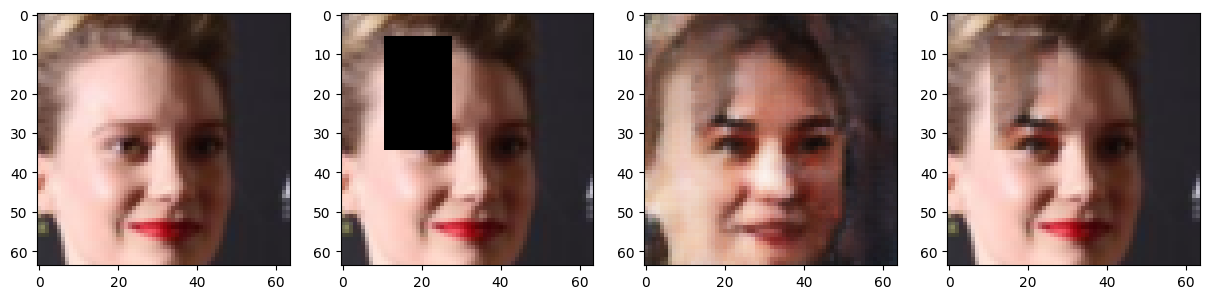

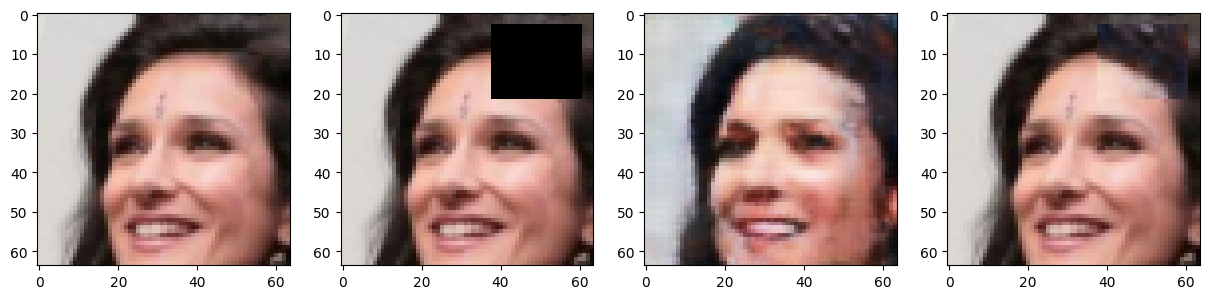

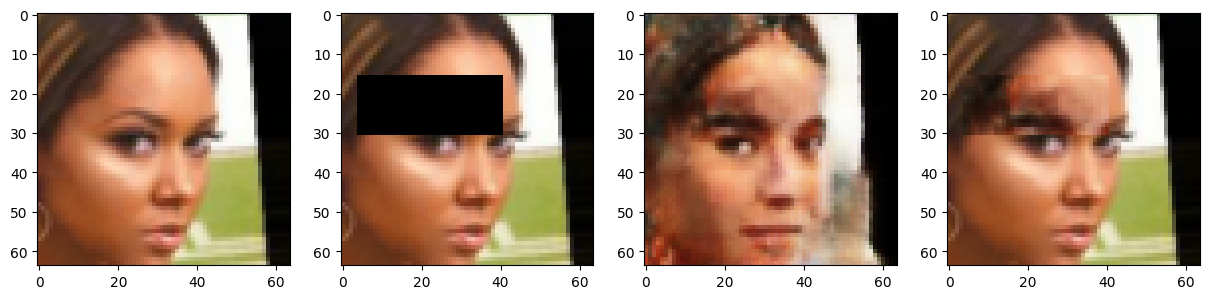

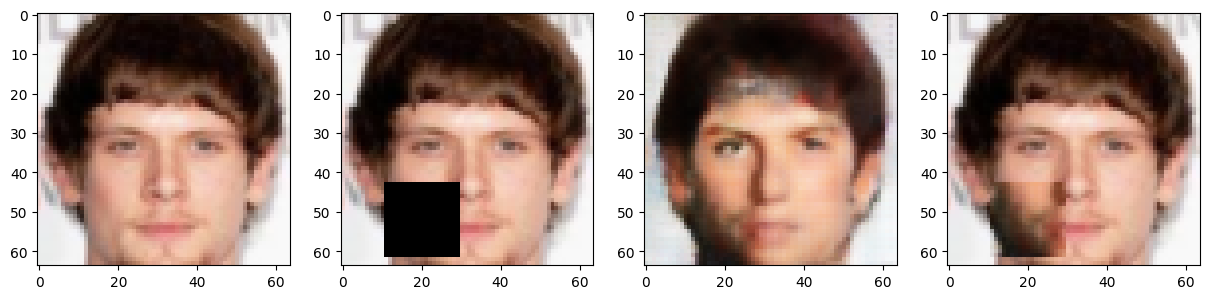

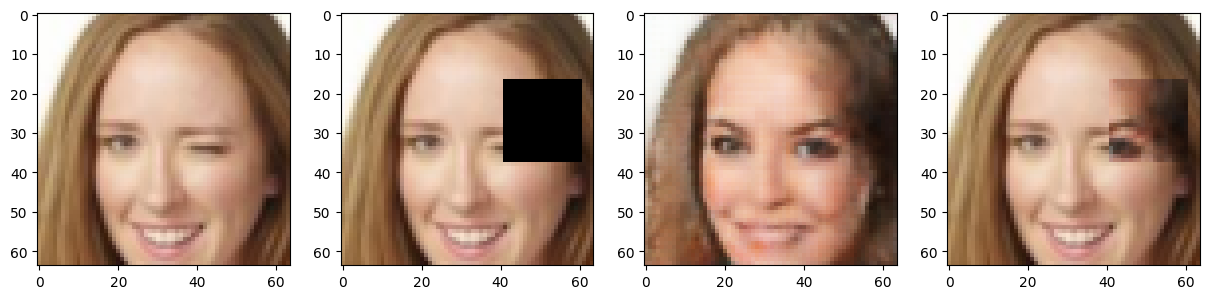

In [ ]:
model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/general-inpainter-big.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteRandomBigRectangle()

for img_index in [8,12,53,1256,1212,99,231,613,71316,131313]:
    display_reconstruction(model, img_index, deletion, labels=[0])

## Removing glasses

In [55]:
# Find indices of images with glasses

glasses_index = []

for i, (_, label) in enumerate(celeba.CelebA(root='.', download=False, transform=transform, split="valid", target_attributes="Eyeglasses")):
    if label==1:
        glasses_index.append(i)
        if len(glasses_index) >= 10:
            break

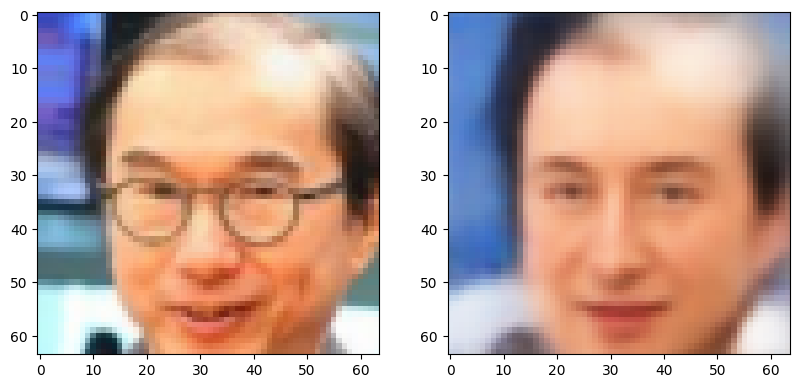

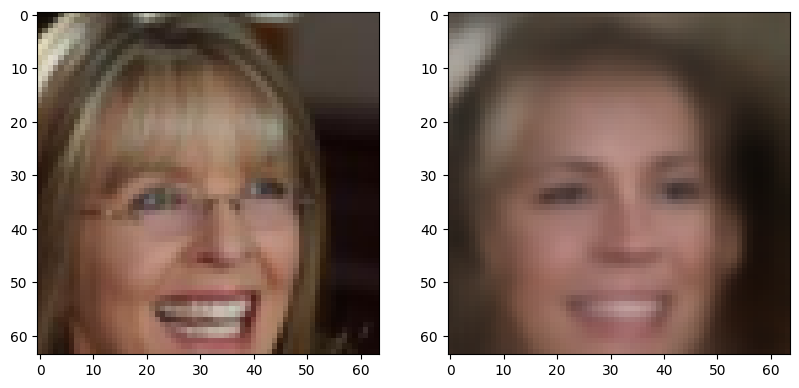

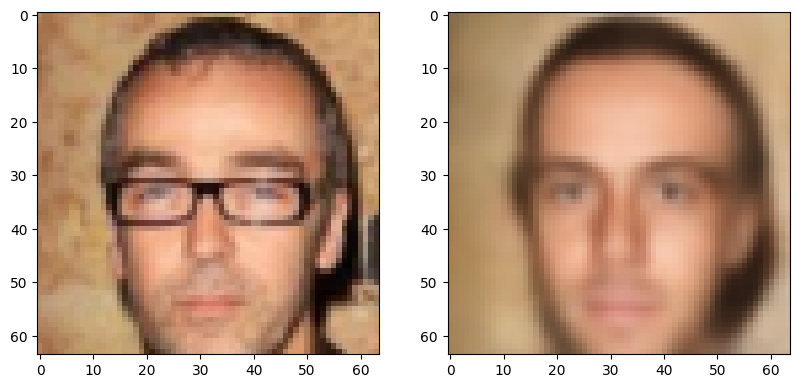

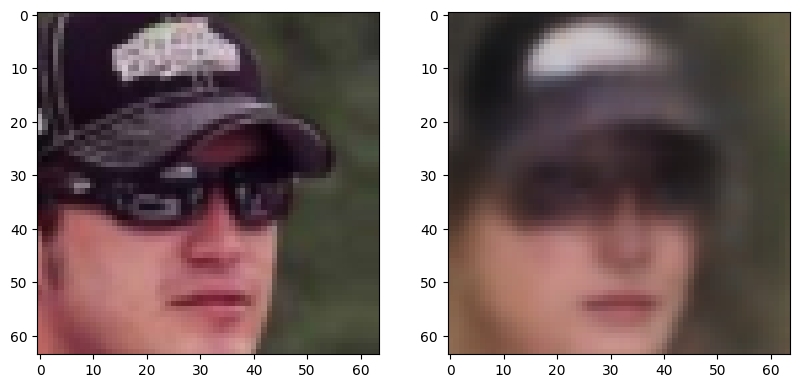

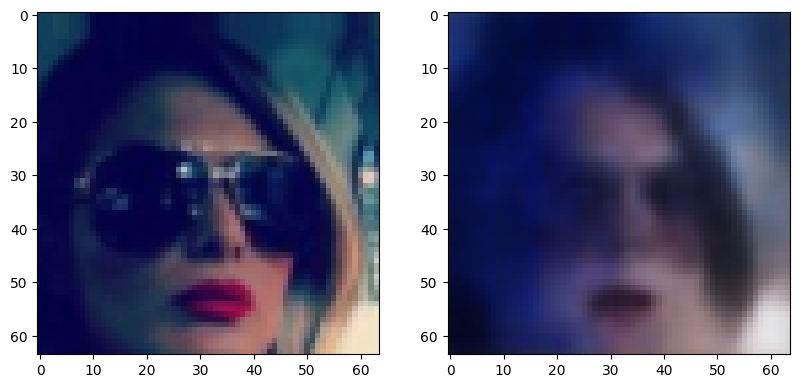

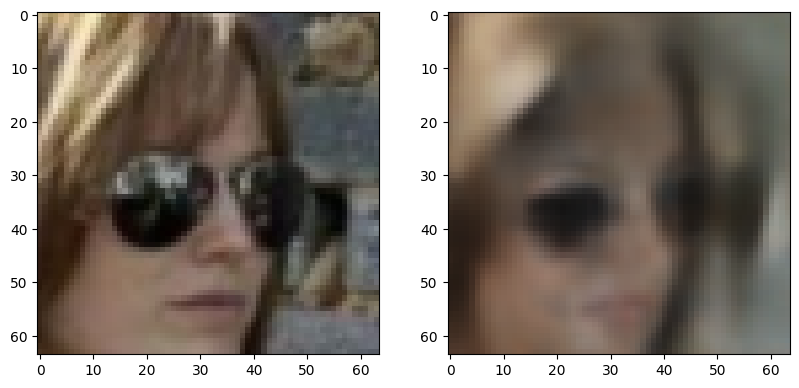

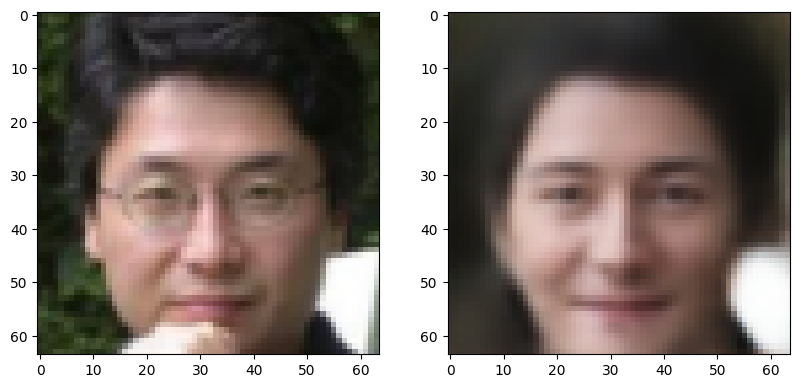

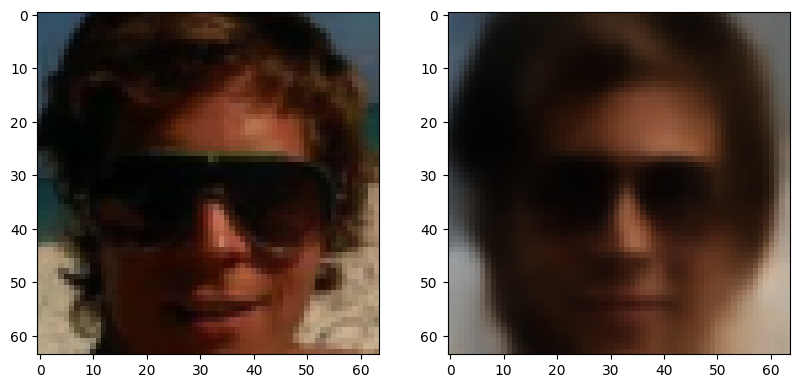

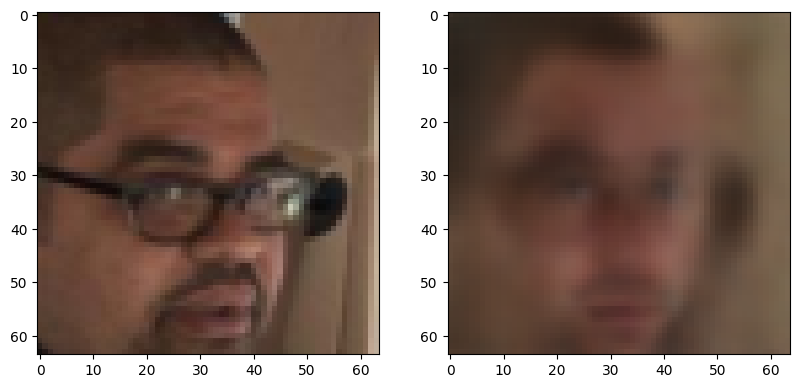

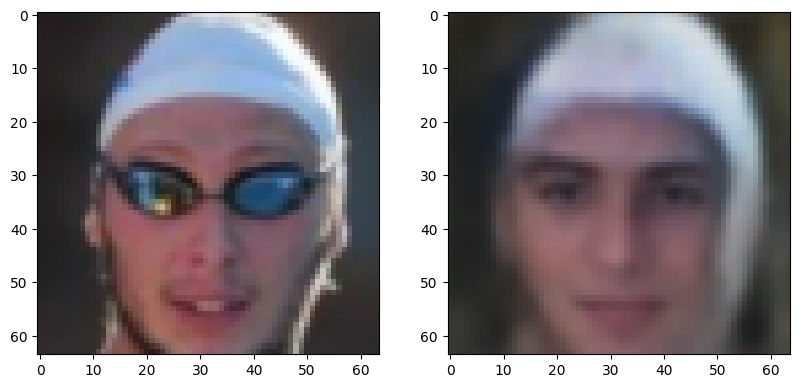

In [56]:
# Baseline cVAE

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/glasses-remover.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

for img_index in glasses_index:
    display_reconstruction_no_deletion(model, img_index, labels=[0])